# PINNs et Balistique avec frottement *(work in progress...)*

> Ce notebook est basé sur le post de Ben Moseley (https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/). On cherche ici à appliquer la méthode des réseaux de neurones informés par la physique (PINNs) à un autre problème physique, en l'occurrence un problème de balistique.

<div style="text-align: center;">
    <img src="https://vicmat.com/wp-content/uploads/2018/05/Captura-300x239.jpg" style="width:400px;"> 

### Modèle

On se place dans un repère orthonormé $(Oxz)$ et on modélise la trajectoire d'un projectile de masse $m$ lancé avec une vitesse $\vec{v_0}$ à $t=0$. 
En prenant en compte les effets de frottement de l'air, les équations du mouvement sont

\begin{align}
m \ddot{z} &= -mg-b\dot{z} \\
m \ddot{x} &= -b\dot{x}
\end{align}

où $b$ est le coefficient de frottement $(b>0)$. En posant $\tau = \frac{m}{b}$, on peut montrer que les solutions s'écrivent

\begin{align}
z &= -\tau gt+(\tau^2 g + \tau\dot{z}(0))(1-e^{-t/\tau}) \\
x &= \dot{x}(0) \tau (1-e^{-t/\tau}).
\end{align}

> Équations tirées du MOOC Mécanique de l'EPFL (https://www.youtube.com/watch?v=zT2cGarzaok).

<br>

### Fonction de coût PINNs

L'équation différentielle liée à la hauteur $z$ de notre projectile s'écrit

$$ \displaystyle \ddot{z} =-g-\frac{1}{\tau }\dot{z}.$$

Dans le cadre ici de notre réseau PINNs, la fonction de coût a alors pour expression

$$\displaystyle \text{Loss}_{\text{PINNs}} =\underbrace{\frac{1}{N}\sum _{i}^{N}( u_{\text{NN}}( x_{i} ;\theta ) -u_{\text{true}}( x_{i}))^{2}}_{\text{data loss}} +\underbrace{\frac{\lambda}{M}\sum _{j}^{M}\left(\left[\frac{d^{2}}{dt^{2}} +\frac{1}{\tau }\frac{d}{dt}\right] u_{\text{NN}}( x_{j} ;\theta ) +g\right)^{2}}_{\text{physics loss}}$$

où $\lambda$ est un poids à fixer.

### Fully connected neural network for PINNs

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import torch
import torch.nn as nn

In [13]:
class FCNN_PINNs(nn.Module):
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS, N_EPOCHS, physics_loss, physics_train_pts):
        super().__init__()
        self.N_EPOCHS = N_EPOCHS
        activation = nn.Tanh
        self.input_layer = nn.Sequential(*[
                                nn.Linear(N_INPUT, N_HIDDEN),
                                activation()])
        self.hidden_layer = nn.Sequential(*[
                                nn.Sequential(*[
                                nn.Linear(N_HIDDEN, N_HIDDEN),
                                activation()]) for _ in range(N_LAYERS-1)])
        self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, X):
        X = self.input_layer(X)
        X = self.hidden_layer(X)
        X = self.output_layer(X)
        return X

    def fit(self, X, Y):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        losses = []
        for i in range(self.N_EPOCHS):
            optimizer.zero_grad()
            data_loss = torch.mean((self.forward(X)-Y)**2) # mean squared error 
            loss = data_loss + physics_loss(self) # loss totale
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        return losses

    def predict(self, X):
        self.eval()
        out = self.forward(X)
        return out.detach()

### Implémentation de loss physique

In [14]:
def physics_loss(model):
    
    z_physics_train = model(physics_train_pts) # hauteurs z pour les points d'entraînement de la physics loss (points de collocation) 
    
    dz_dt = torch.autograd.grad(z_physics_train, physics_train_pts, torch.ones_like(z_physics_train), create_graph=True)[0] # calcul de dz/dt
    d2z_dt2 = torch.autograd.grad(dz_dt, physics_train_pts, torch.ones_like(dz_dt), create_graph=True)[0] # calcul de d^2z/dt^2
    
    eq = d2z_dt2 + (1/tau)*dz_dt + g # équation résiduelle
    loss = torch.mean(eq**2) # mean squared error
    
    return loss

## 1) <ins>Data bruitées sur une petite partie du domaine</ins>

In [15]:
def traj_z(t):
    return -tau*g*t + ( g*(tau**2)+tau*v0*np.sin(theta) )*( 1-np.exp(-t/tau) )

def traj_x(t):
    return v0*np.cos(theta)*tau*( 1-np.exp(-t/tau) )

def plot_traj_x_z(t, t_data, z_data, physics_train_pts=None):
    plt.axhline(y=0, color='k', alpha=0.6)
    plt.axvline(x=0, color='k', alpha=0.6)
    plt.plot(traj_x(t), traj_z(t), color='grey', label='trajectoire exacte', alpha=0.6)
    plt.plot(traj_x(t_data), z_data, 'o', color='orange', label='mesures', alpha=0.6)
    if physics_train_pts != None:
        plt.plot( traj_x(physics_train_pts), np.zeros(len(physics_train_pts)), 'o', 
                  color='mediumseagreen', label='points entraînement physics loss', alpha=0.6)
    plt.xlabel(r'$x(t)$ [m]')
    plt.ylabel(r'$z(t)$ [m]')
    plt.legend()
    
def plot_t_z(t, z_pred, physics_train_pts=None):
    plt.axhline(y=0, color='k', alpha=0.6)
    plt.axvline(x=0, color='k', alpha=0.6)
    plt.plot(t, z_pred, color='royalblue', label='prédiction', alpha=0.6)
    plt.plot(t, traj_z(t), color='grey', label='solution exacte', alpha=0.6)
    if physics_train_pts != None:
        plt.plot( physics_train_pts, np.zeros(len(physics_train_pts)), 'o',
                  color='mediumseagreen', label='points entraînement physics loss', alpha=0.6)
    plt.xlabel(r'temps $t$ [s]')
    plt.ylabel(r'$z(t)$ [m]')
    plt.legend()

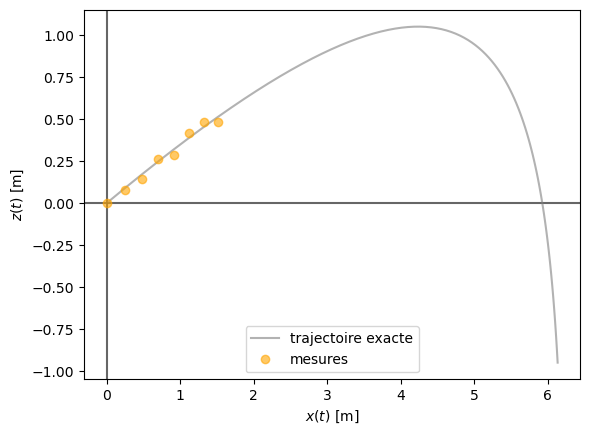

In [43]:
g = 9.81   # intensité de pesanteur (m/s^2)
v0 = 20    # vitesse à t=0 (m/s)
m = 5      # masse du projectile (kg)
b = 15     # coefficient de frottement 
tau = m/b
theta = np.radians(20) # angle de tir

t = torch.linspace(0, 1.3, 100).view(-1,1) # intervalle de temps 

t_data = t[0:8] # nombre de mesures
t_data = t_data.squeeze()

z_data = traj_z(t_data) + 0.03*torch.randn(len(t_data)) # mesures bruitées
z_data[0] = 0

plot_traj_x_z(t, t_data, z_data)

### Entraînement du réseau PINNs

In [44]:
physics_train_pts = torch.linspace(0, 1.05, 20).view(-1,1).requires_grad_(True) # points d'entraînement pour notre physics loss (points de collocation)

epochs = 10000

model = FCNN_PINNs(1, 1, 32, 3, epochs, physics_loss, physics_train_pts) # réseau à 3 couches de 32 neurones

PINNs_loss = model.fit(t_data.view(-1,1), z_data.view(-1, 1))

z_pred = model.predict(t) # prédiction des hauteurs z

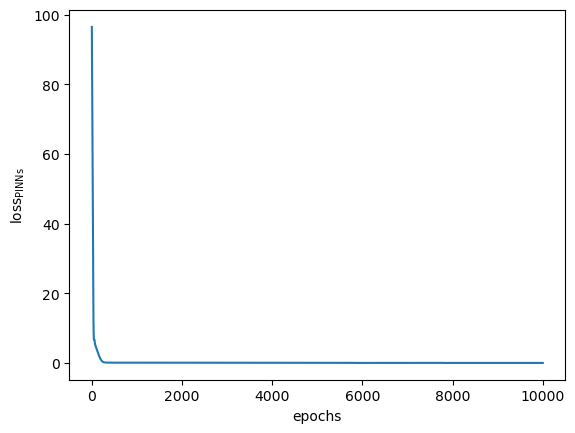

In [45]:
plt.xlabel('epochs')
plt.ylabel(r'$\text{loss}_{\text{PINNs}}$')
plt.plot(PINNs_loss)

In [46]:
print('--- Indicateur : MSE \n')
for i in range(epochs):
    if i % 200 == 0: 
        print('epoch', i, ' --- ', 'loss_pinns = ', PINNs_loss[i])
print('epoch', i+1, ' --- ', 'loss_pinns = ', PINNs_loss[i])

--- Indicateur : MSE 

epoch 0  ---  loss_pinns =  96.4647216796875
epoch 200  ---  loss_pinns =  0.9499074220657349
epoch 400  ---  loss_pinns =  0.07908561080694199
epoch 600  ---  loss_pinns =  0.07397624105215073
epoch 800  ---  loss_pinns =  0.07244202494621277
epoch 1000  ---  loss_pinns =  0.07143329083919525
epoch 1200  ---  loss_pinns =  0.07071243226528168
epoch 1400  ---  loss_pinns =  0.07012328505516052
epoch 1600  ---  loss_pinns =  0.06958433240652084
epoch 1800  ---  loss_pinns =  0.06906045228242874
epoch 2000  ---  loss_pinns =  0.06853844970464706
epoch 2200  ---  loss_pinns =  0.06801223754882812
epoch 2400  ---  loss_pinns =  0.06747657805681229
epoch 2600  ---  loss_pinns =  0.06692547351121902
epoch 2800  ---  loss_pinns =  0.06635312736034393
epoch 3000  ---  loss_pinns =  0.06575321406126022
epoch 3200  ---  loss_pinns =  0.0651145651936531
epoch 3400  ---  loss_pinns =  0.06440974026918411
epoch 3600  ---  loss_pinns =  0.0635763630270958
epoch 3800  ---  loss

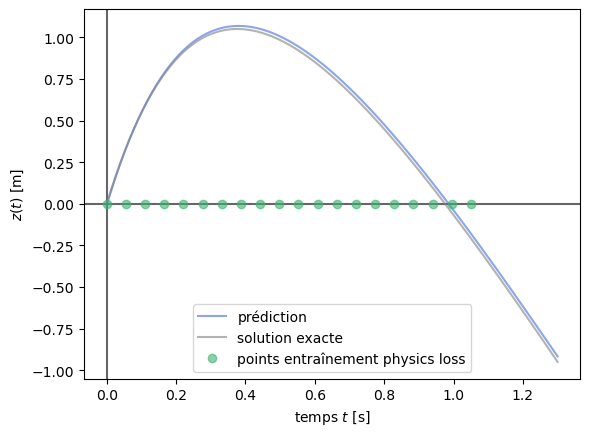

In [47]:
physics_train_pts = physics_train_pts.detach()

plot_t_z(t, z_pred, physics_train_pts)

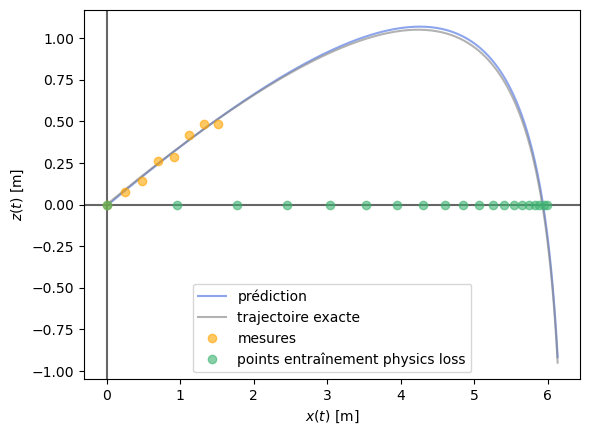

In [48]:
plt.plot( traj_x(t), z_pred, color='royalblue', label='prédiction', alpha=0.6)

plot_traj_x_z(t, t_data, z_data, physics_train_pts)

## 2) <ins>Data bruitées sur l'ensemble du domaine</ins>

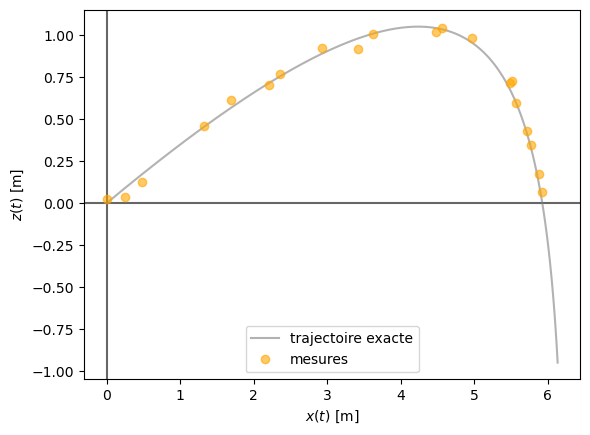

In [106]:
t_data, id = torch.sort(t[0:75][torch.randperm(t[0:75].size(0))[:20]]) # tire aléatoirement 20 points dans l'intervalle t 
t_data = t_data.squeeze()

z_data = traj_z(t_data) + 0.03*torch.randn(len(t_data)) # mesures bruitées

plot_traj_x_z(t, t_data, z_data)

In [107]:
physics_train_pts = torch.linspace(0, 1.05, 20).view(-1,1).requires_grad_(True) # points d'entraînement pour notre physics loss (points de collocation)

epochs = 10000

model2 = FCNN_PINNs(1, 1, 32, 3, epochs, physics_loss, physics_train_pts) # réseau à 3 couches de 32 neurones

loss_PINNs = model2.fit(t_data.view(-1,1), z_data.view(-1, 1))

z_pred = model2.predict(t) # prédiction des hauteurs z

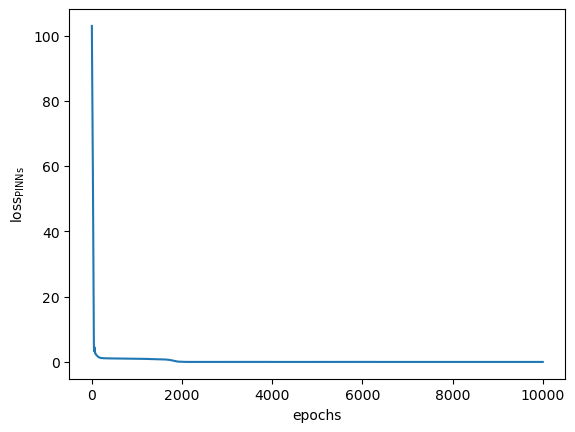

In [108]:
plt.xlabel('epochs')
plt.ylabel(r'$\text{loss}_{\text{PINNs}}$')
plt.plot(loss_PINNs)

In [109]:
print('--- Metric: MSE \n')
for i in range(epochs):
    if i % 200 == 0: 
        print('epoch', i, ' --- ', 'loss_pinns = ', loss_PINNs[i])
print('epoch', i+1, ' --- ', 'loss_pinns = ', loss_PINNs[i])

--- Metric: MSE 

epoch 0  ---  loss_pinns =  102.95391845703125
epoch 200  ---  loss_pinns =  1.2132211923599243
epoch 400  ---  loss_pinns =  1.0772948265075684
epoch 600  ---  loss_pinns =  1.0354150533676147
epoch 800  ---  loss_pinns =  1.0091499090194702
epoch 1000  ---  loss_pinns =  0.9763574004173279
epoch 1200  ---  loss_pinns =  0.9226087331771851
epoch 1400  ---  loss_pinns =  0.8591183423995972
epoch 1600  ---  loss_pinns =  0.7700178027153015
epoch 1800  ---  loss_pinns =  0.39219212532043457
epoch 2000  ---  loss_pinns =  0.02534756436944008
epoch 2200  ---  loss_pinns =  0.0020807927940040827
epoch 2400  ---  loss_pinns =  0.0013235684018582106
epoch 2600  ---  loss_pinns =  0.0012140304315835238
epoch 2800  ---  loss_pinns =  0.0011699215974658728
epoch 3000  ---  loss_pinns =  0.0012355350190773606
epoch 3200  ---  loss_pinns =  0.0011148237390443683
epoch 3400  ---  loss_pinns =  0.001087966258637607
epoch 3600  ---  loss_pinns =  0.0010701841674745083
epoch 3800  --

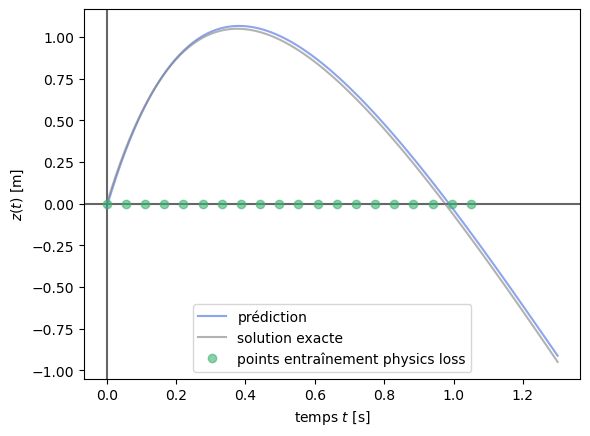

In [110]:
physics_train_pts = physics_train_pts.detach()

plot_t_z(t, z_pred, physics_train_pts)

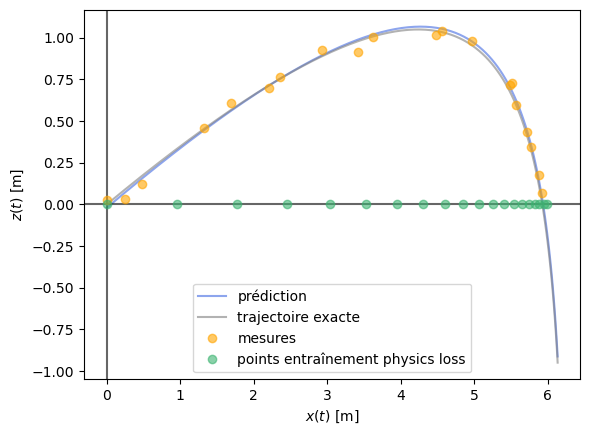

In [111]:
plt.plot(traj_x(t), z_pred, color='royalblue', label='prédiction', alpha=0.6)

plot_traj_x_z(t, t_data, z_data, physics_train_pts)

## 3) <ins>Problème inverse : estimation du paramètre $\tau$ </ins>

In [112]:
class FCNN_PINNs_parameter(nn.Module):
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS, N_EPOCHS, physics_loss, physics_train_pts):
        super().__init__()

        self.N_EPOCHS = N_EPOCHS
        self.physics_loss = physics_loss
        self.param = nn.Parameter(data=torch.tensor([1.], requires_grad=True))
        self.params = []
        activation = nn.Tanh
        
        self.input_layer = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.hidden_layer = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, X):
        X = self.input_layer(X)
        X = self.hidden_layer(X)
        X = self.output_layer(X)
        return X

    def fit(self, X, Y):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        losses = []
        for i in range(self.N_EPOCHS):
            optimizer.zero_grad()
            data_loss = torch.mean((self.forward(X)-Y)**2) # mean squared error 
            loss = data_loss + self.physics_loss(self) # loss totale
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            self.params.append(self.param.item())
        return losses

    def predict(self, X):
        self.eval()
        out = self.forward(X)
        return out.detach()

In [113]:
def physics_loss_parameter(model):
    
    z_physics_train = model(physics_train_pts) # hauteurs z pour les points d'entraînement de la physics loss (points de collocation) 
    
    dz_dt  = torch.autograd.grad(z_physics_train, physics_train_pts, torch.ones_like(z_physics_train), create_graph=True)[0] # calcul de dz/dt
    d2z_dt2 = torch.autograd.grad(dz_dt, physics_train_pts, torch.ones_like(dz_dt), create_graph=True)[0] # calcul de d^2z/dt^2
    
    eq = d2z_dt2 + (1/model.param)*dz_dt + g # équation résiduelle 
    loss = torch.mean(eq**2) # mean squared error 
    
    return loss

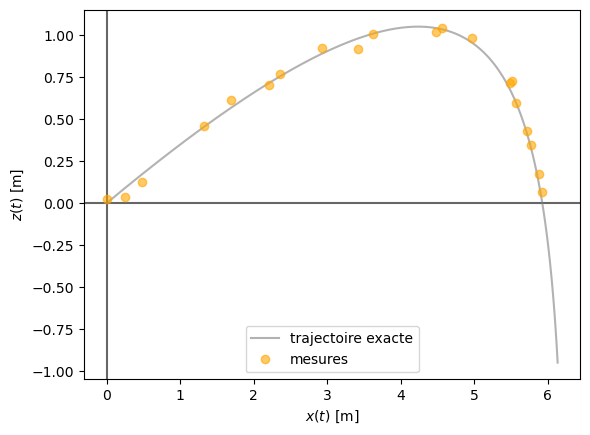

In [114]:
plot_traj_x_z(t, t_data, z_data)

In [115]:
physics_train_pts = torch.linspace(0, 1.05, 20).view(-1,1).requires_grad_(True) # points d'entraînement pour notre physics loss (points de collocation)

epochs = 40000

model_parameter = FCNN_PINNs_parameter(1, 1, 32, 3, epochs, physics_loss_parameter, physics_train_pts) # réseau à 3 couches de 32 neurones

loss_PINNs = model_parameter.fit(t_data.view(-1,1), z_data.view(-1, 1))

z_pred = model_parameter.predict(t) # prédiction des hauteurs z

In [116]:
print('--- Metric: MSE \n')
for i in range(epochs):
    if i % 200 == 0: 
        print('epoch', i, ' --- ', 'loss_pinns = ', loss_PINNs[i])
print('epoch', i+1, ' --- ', 'loss_pinns = ', loss_PINNs[i])

--- Metric: MSE 

epoch 0  ---  loss_pinns =  96.9859848022461
epoch 200  ---  loss_pinns =  3.2691049575805664
epoch 400  ---  loss_pinns =  2.2996716499328613
epoch 600  ---  loss_pinns =  1.8569493293762207
epoch 800  ---  loss_pinns =  1.1386882066726685
epoch 1000  ---  loss_pinns =  0.07393138110637665
epoch 1200  ---  loss_pinns =  0.004790072795003653
epoch 1400  ---  loss_pinns =  0.003988918848335743
epoch 1600  ---  loss_pinns =  0.004258830100297928
epoch 1800  ---  loss_pinns =  0.0038201597053557634
epoch 2000  ---  loss_pinns =  0.0037938100285828114
epoch 2200  ---  loss_pinns =  0.0037782967556267977
epoch 2400  ---  loss_pinns =  0.0038120399694889784
epoch 2600  ---  loss_pinns =  0.012270364910364151
epoch 2800  ---  loss_pinns =  0.0037405644543468952
epoch 3000  ---  loss_pinns =  0.0037271513137966394
epoch 3200  ---  loss_pinns =  0.0041847825050354
epoch 3400  ---  loss_pinns =  0.0037240474484860897
epoch 3600  ---  loss_pinns =  0.003687191754579544
epoch 380

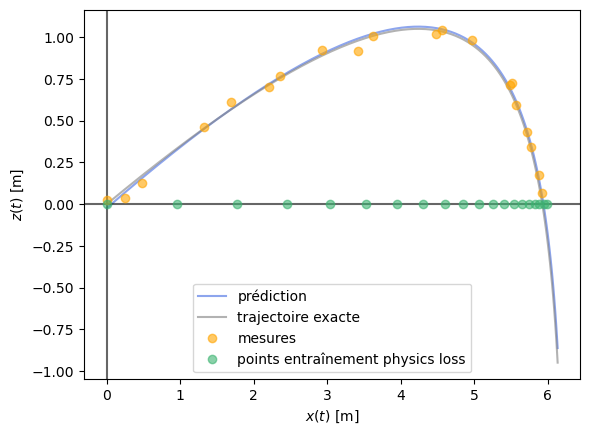

In [117]:
physics_train_pts = physics_train_pts.detach()

plt.plot(traj_x(t), z_pred, color='royalblue', label='prédiction', alpha=0.6)

plot_traj_x_z(t, t_data, z_data, physics_train_pts)

In [118]:
print(r'Paramètre estimé : τ = ', model_parameter.param.item())
print(r'Valeur exacte : τ = ', tau)

Paramètre estimé : τ =  0.31269124150276184
Valeur exacte : τ =  0.3333333333333333


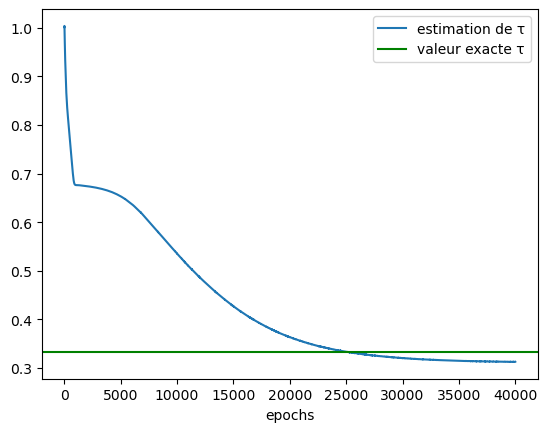

In [119]:
plt.plot(model_parameter.params, label='estimation de τ')
plt.xlabel(r'epochs')
plt.axhline(y=tau, color='g', label='valeur exacte τ')
plt.legend()